In [3]:
from src.train import train_epoch, evaluate
import torch
from src.train.config import *
from src.preprocessing.config import *
from src.preprocessing import vocab_transform
from src.models.transformer import Seq2SeqTransformer
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from timeit import default_timer as timer
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
MODELS_PATH = '../data/interim/transf_cp.tar'
import warnings
warnings.filterwarnings('ignore')
from torch.optim.lr_scheduler import ReduceLROnPlateau

KeyError: 'de'

In [2]:
INITIAL_TRAIN = True

In [3]:
SRC_VOCAB_SIZE, TGT_VOCAB_SIZE

(29219, 21826)

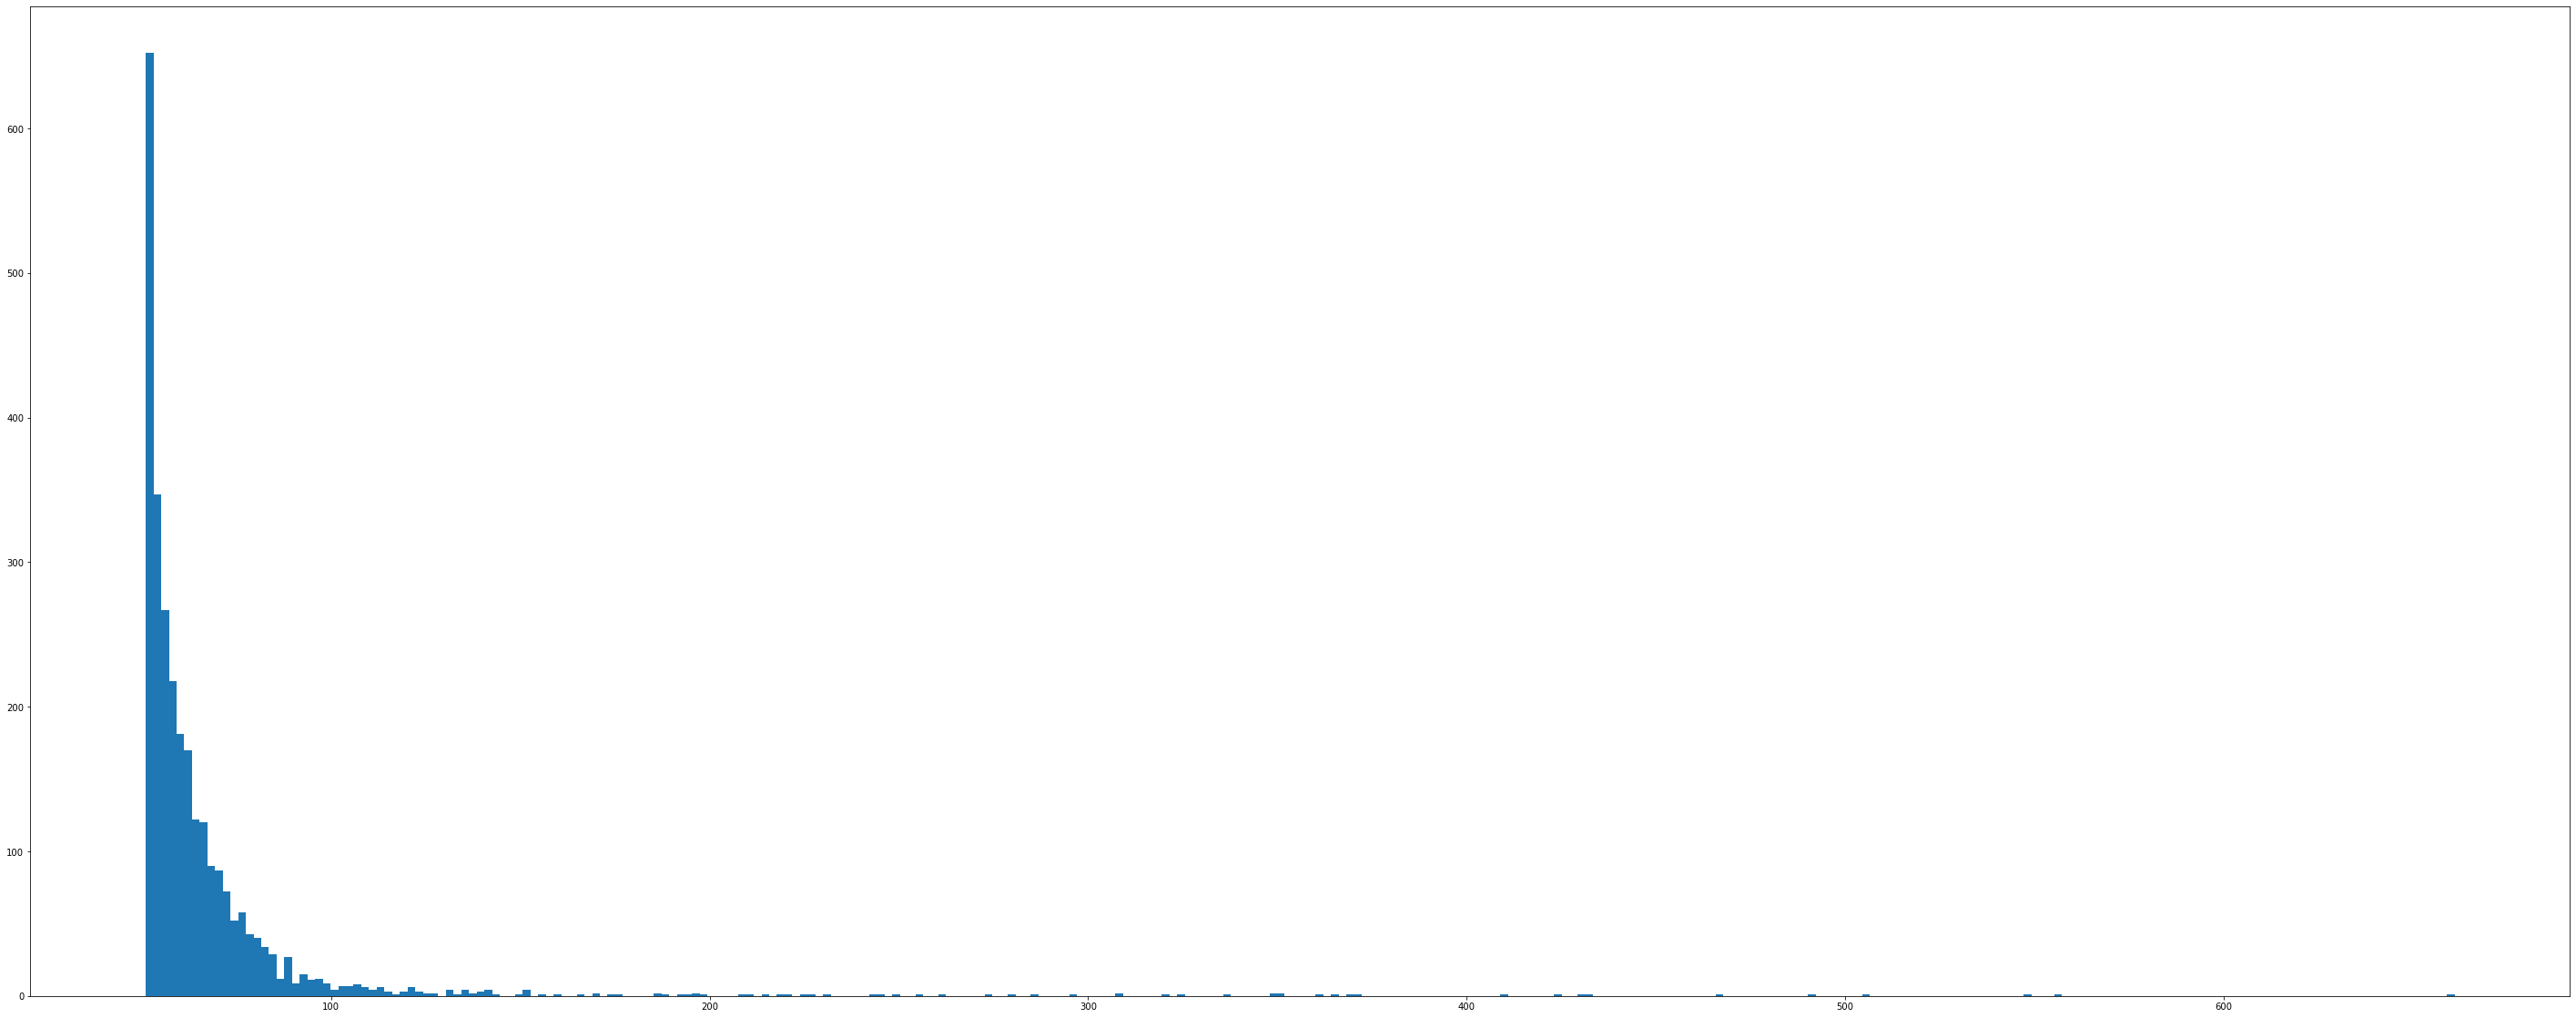

In [12]:
from pathlib import Path
import math
import matplotlib.pyplot as plt

de_path = Path(r'/home/user/.torchtext/cache/IWSLT2016/2016-01/texts/de/en/de-en/train.de-en.de')
en_path = Path(r'/home/user/.torchtext/cache/IWSLT2016/2016-01/texts/de/en/de-en/train.de-en.en')

def get_sentence_len(line):
    return len(line.split())


with open(de_path) as file:
    lines = file.readlines()
    sentences_lens = list(filter(lambda x: x > 50, [get_sentence_len(line) for line in lines]))
    plt.figure(figsize=(50, 20))
    plt.hist(sentences_lens, bins=300)


In [4]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
transformer = transformer.to(DEVICE)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
if INITIAL_TRAIN:
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

else:
    checkpoint = torch.load(MODELS_PATH, map_location=DEVICE)
    transformer.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    #loss = checkpoint['loss'] 


In [5]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

In [6]:
def train_wrapper(last_epoch,epochs_num, model, optimizer,  scheduler, loss_fn, run_name):
    global_val_loss = 1e10
    writer = SummaryWriter(f'../data/interim/runs/{run_name}')
    for epoch in range(last_epoch + 1, last_epoch + epochs_num + 1):
        start_time = timer()
        train_loss = train_epoch(model, optimizer, loss_fn, dataset_type='both')
        end_time = timer()
        val_loss = evaluate(model, loss_fn, dataset_type='both')
        scheduler.step(val_loss)
        writer.add_scalars('Training vs validation loss', {'Training': train_loss, 'Validation': val_loss}, epoch)
        if val_loss < global_val_loss:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model.state_dict()},
            f'../data/interim/runs/{run_name}/transf_cp.tar',
            )
            print('## Vall loss decreased, model succefully saved ##')
            global_val_loss = val_loss
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    writer.flush()

In [8]:
train_wrapper(0, 18, transformer, optimizer, scheduler, loss_fn, 'main_dset_e1-18')

## Vall loss decreased, model succefully saved ##
Epoch: 1, Train loss: 15.971, Val loss: 17.381, Epoch time = 5917.196s
Epoch: 2, Train loss: 15.786, Val loss: 19.120, Epoch time = 5807.980s
Epoch: 3, Train loss: 16.150, Val loss: 20.005, Epoch time = 5812.510s
Epoch 00004: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4, Train loss: 16.010, Val loss: 20.085, Epoch time = 5805.222s
Epoch: 5, Train loss: 16.755, Val loss: 19.710, Epoch time = 5809.901s
Epoch: 6, Train loss: 16.630, Val loss: 19.610, Epoch time = 5821.676s


KeyboardInterrupt: 